In [1]:
!pip install tensorflow numpy pandas seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, AvgPool2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import sigmoid

---

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Plotting a sample

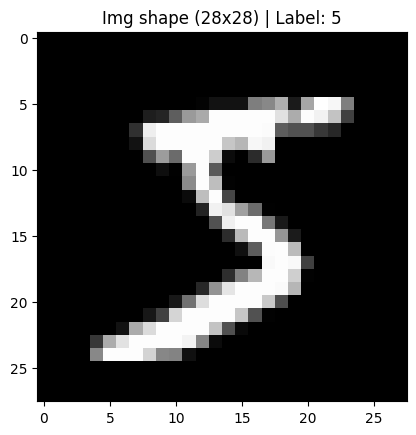

In [4]:
sample_idx = 0

plt.imshow(x_train[sample_idx], cmap='gray')
plt.title(f'Img shape ({x_train[sample_idx].shape[0]}x{x_train[sample_idx].shape[1]}) | Label: {y_train[sample_idx]}')
plt.show()

## One-hot Encoding the labels

In [5]:
y_train_oh = keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = keras.utils.to_categorical(y_test, num_classes=10)

## Normalizing input

In [6]:
x_train = x_train/255
x_test = x_test/255

---

# Neural Network

In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

Note:

1. The original paper says: "The four inputs to a unit in S2 are added then multiplied by a trainable coeficient and added to a trainable bias. The result is passed through a sigmoidal function". We will replace this for an average pooling layer.
2. LeNet5 uses a convolutional layer (C5) to flatten the output that is the same as a dense layer, since a 5x5 kernel is applied to 5x5 feature maps. We will use the original implementation, but since the keras output of a Conv2D layer has a shape (batch_size, 1, 1, N) instead of (batch_size, N) we need to follow with a flatten layer to unsqueeze the unitary dimensions.
3. Some changes to the network were made: Activation of the last layer was changed to softmax; Optimizer was replaced for Adam and loss for categorical crossentropy.

Original Paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [8]:
model = Sequential()

model.add(Conv2D(name='C1', filters=6, kernel_size=(5,5), strides=1, input_shape=(28,28,1), padding='same')) # Original paper uses 32x32 images, since mnist has 28x28, i used padding with a 5x5 kernel (making the input image 32x32)
model.add(AvgPool2D(name='S2', pool_size=(2,2), strides=2))
model.add(Activation(name='Sigmoid1', activation=sigmoid))
model.add(Conv2D(name='C3', filters=16, kernel_size=(5,5), strides=1))
model.add(AvgPool2D(name='S4', pool_size=(2,2), strides=2))
model.add(Activation(name='Sigmoid2', activation=sigmoid))
model.add(Conv2D(name='C5', filters=120, kernel_size=(5,5)))
model.add(Flatten(name='Flatten'))
model.add(Dense(name='F6', units=84, activation='relu'))
model.add(Dense(name='OUTPUT', units=10, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        keras.metrics.CategoricalAccuracy(name='Accuracy'),
        keras.metrics.Precision(name='Precision'),
        keras.metrics.Recall(name='Recall'),
        keras.metrics.F1Score(name='F1', average='micro'),
    ]
)

model.summary()

c:\Users\12ped\anaconda3\envs\biopotenciais\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                     │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S2 (AveragePooling2D)           │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sigmoid1 (Activation)           │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C3 (Conv2D)                     │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ S4 (AveragePooling2D)           │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sigmoid2 (Activation)           │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ C5 (Conv2D)                     │ (None, 1, 1, 120)      │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ F6 (Dense)                      │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    x=x_train,
    y=y_train_oh,
    batch_size=50,
    epochs=100,
    shuffle=True,
    validation_data=(x_test, y_test_oh),
    callbacks=[early_stopping],
)

Epoch 1/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - Accuracy: 0.4376 - F1: 0.4376 - Precision: 0.6991 - Recall: 0.3343 - loss: 1.5120 - val_Accuracy: 0.9326 - val_F1: 0.9326 - val_Precision: 0.9455 - val_Recall: 0.9219 - val_loss: 0.2131
Epoch 2/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Accuracy: 0.9334 - F1: 0.9334 - Precision: 0.9452 - Recall: 0.9244 - loss: 0.2090 - val_Accuracy: 0.9532 - val_F1: 0.9532 - val_Precision: 0.9634 - val_Recall: 0.9466 - val_loss: 0.1441
Epoch 3/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Accuracy: 0.9541 - F1: 0.9541 - Precision: 0.9604 - Recall: 0.9490 - loss: 0.1423 - val_Accuracy: 0.9625 - val_F1: 0.9625 - val_Precision: 0.9665 - val_Recall: 0.9582 - val_loss: 0.1244
Epoch 4/100
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Accuracy: 0.9656 - F1: 0.9656 - Precision: 0.9698 - Recall: 0.9623 - loss: 0.1115 - val_Accuracy: 0.9693 - val_F1: 0.9693 - val_Precision: 0.9737 - val_Recall: 0.9670 - val_loss: 0.0908
Epoch 5/100
1200/1200 ━━━━━━

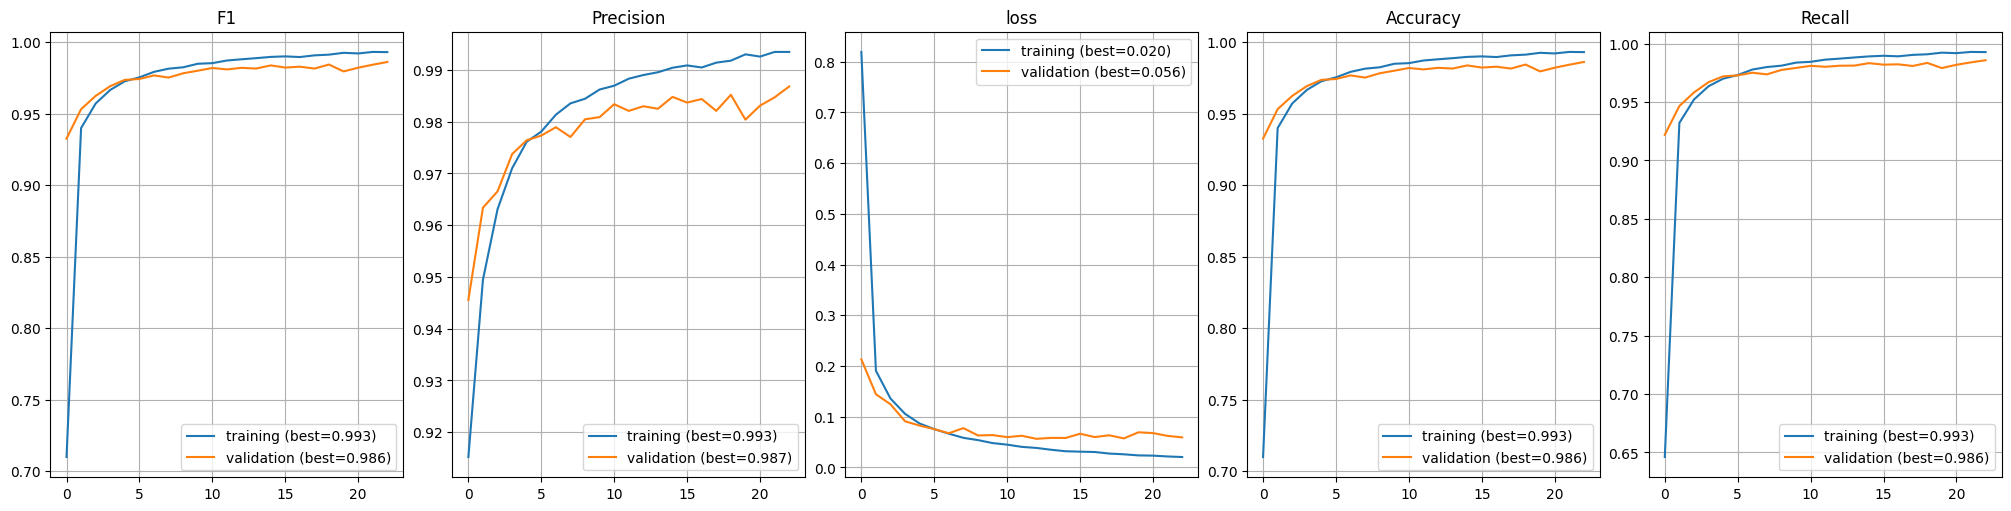

In [10]:
h_df = pd.DataFrame(history.history)

metrics = set([k.split('_')[-1] for k in history.history.keys()])

fig, axs = plt.subplots(ncols=len(metrics), nrows=1, constrained_layout=True, figsize=(20,5))

for plot_idx, metric in enumerate(metrics):
    best = h_df.max(0) if metric != 'loss' else h_df.min(0)
    axs[plot_idx].plot(
        history.history[metric],
        label=f'training (best={best[metric]:.3f})'
    )
    axs[plot_idx].plot(
        history.history['val_'+metric],
        label=f'validation (best={best["val_"+metric]:.3f})'
    )
    axs[plot_idx].grid(True)
    axs[plot_idx].set_title(metric)
    axs[plot_idx].legend()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Axes: >

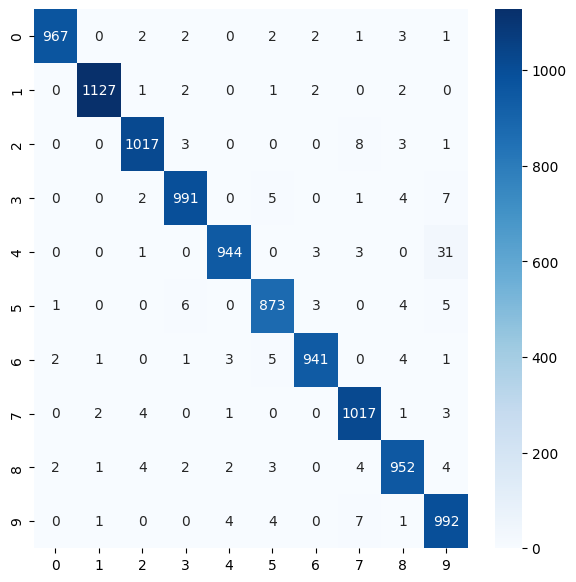

In [11]:
y_prediction = model.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)

cf_matrix = confusion_matrix(y_test, y_prediction, normalize=None)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues', ax=ax)